## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [451]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [452]:
df=pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [453]:
dfsize=df.count()[0]
dfsize

294478

c. The number of unique users in the dataset.

In [454]:
uniqueusers=df.user_id.value_counts()
uniqueusers.size

#use alternatively df.groupby("group").nunique("user_id") in order to get unique users by group

290584

d. The proportion of users converted.

In [455]:
(df[df.converted==1].count())/df.count()

user_id         0.119659
timestamp       0.119659
group           0.119659
landing_page    0.119659
converted       0.119659
dtype: float64

e. The number of times the `new_page` and `treatment` don't line up.

In [456]:
oldPageTreat=((df["landing_page"]=="old_page") & (df["group"]=="treatment"))
newPageCont=((df["landing_page"]=="new_page") & (df["group"]=="control"))

display((np.sum(oldPageTreat))+(np.sum(newPageCont)))#total number of mismatches

3893

f. Do any of the rows have missing values?

In [457]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [459]:
df2=df[~oldPageTreat&~newPageCont]

In [460]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [461]:
uniqueusersdf2=df2.user_id.value_counts()
uniqueusersdf2.size

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [462]:
uniqueusersdf2[uniqueusersdf2==2]

773192    2
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [463]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [464]:
df2=df2[df2.index!=2893]

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [465]:
df2[df2.converted==1].count()[0]/df2.count()[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [466]:
controldf=df2[df2.group=="control"]
controldf[controldf.converted==1].count()[0]/controldf.count()[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [467]:
treatmentdf=df2[df2.group=="treatment"]
treatmentdf[treatmentdf.converted==1].count()[0]/treatmentdf.count()[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [468]:
df2[df2.landing_page=="new_page"].count()[0]/df2.count()[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

At the current stage, we notice a (slight) difference between the ratio of users converted between those landing in the new and the old landing page. However, the old landing page seems to give better results than the new landing page (with 12% of users converted against 11.8% for the new landing page). With the data available, it seems then that the new landing page is in fact performing *worse* than the old landing page. We can still perform a z test in order to assess if this difference is due to chance (and then that in fact we cannot rule out that the two pages are having the same performance) or that it is due to a factive difference in the performance of the two pages. Either way, the data available at this stage don't show that the new treatment page is leading to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

As mentioned above, we can run a z test in order to ascertain if the difference between the to conversion rates is due to chance or else. In this case, our null hypotesis would be that the old conversion rate is the same of the new conversion rate:

$$H_0: p_{old}-p_{new}=0$$

Conversely, the alternative hypothesis would assume a difference between the two rates, and more specifically in the case presented, that the new page has a better conversion rate than the old one (note that as noted above, this seems already impossible on the basis of the data available).

$$H_1: p_{new}-p_{old}>0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [469]:
nullrate=df2[df2.converted==1].count()[0]/df2.count()[0]
nullrate

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [470]:
nullrate

0.11959708724499628

c. What is $n_{new}$?

In [471]:
nnew=df2[df2.landing_page=="new_page"].count()[0]
nnew

145310

d. What is $n_{old}$?

In [472]:
nold=df2[df2.landing_page=="old_page"].count()[0]
nold

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [473]:
new_page_converted=np.random.binomial(nnew,nullrate)
new_page_converted

17324

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [474]:
old_page_converted=np.random.binomial(nold,nullrate)
old_page_converted

17537

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [477]:
difnewold=new_page_converted/nnew-old_page_converted/nold
difnewold

-0.0014957387772788766

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [519]:
p_diffs=[]
nullrate=df2[df2.converted==1].count()[0]/df2.count()[0]
nnew=df2[df2.landing_page=="new_page"].count()[0]
nold=df2[df2.landing_page=="old_page"].count()[0]
for _ in range(10000):
    new_page_converted=np.random.binomial(nnew,nullrate)
    old_page_converted=np.random.binomial(nold,nullrate)
    diff=new_page_converted/nnew-old_page_converted/nold
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  18.,  134.,  574., 1602., 2639., 2685., 1611.,  600.,  116.,
          21.]),
 array([-4.42762211e-03, -3.53975030e-03, -2.65187849e-03, -1.76400668e-03,
        -8.76134872e-04,  1.17369379e-05,  8.99608748e-04,  1.78748056e-03,
         2.67535237e-03,  3.56322418e-03,  4.45109599e-03]),
 <a list of 10 Patch objects>)

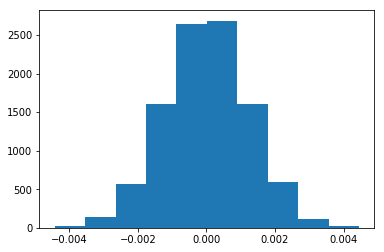

In [520]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [521]:
realdiff=(treatmentdf[treatmentdf.converted==1].count()[0]/treatmentdf.count()[0])-(controldf[controldf.converted==1].count()[0]/controldf.count()[0])
(p_diffs>realdiff).mean()

0.9043

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In the simulation above, we assumed that the new page and the old page had the same conversion rate (and we assumed that this was the same of the overall conversion rate of the whole sample). We simulate how many users would be converted with this rate out of samples of the same size of our sample (divided by landing page). We then computed the proportions of users converted in these simulations, and checked the difference. By its own construction, the result of this simulation would be close to 0, with slight differences due to chance. By the central limit theory, these differences average out when we ran several times the same simulation (10,000 in the case above), with the differences being normally distributed and centred at 0.

In the last part of this simulation, we checked how the actual difference we observed in our sample (about -0.0016) compares with the simulated differences we computed. In other words, we checked where it falls in the distribution of 10,000 differences computed under the null. It turns out that 90% of the computed differences are higher than the difference we obtained. In scientific studies this is called p-value, and it represents how many chances there are to obtain such a value under the null hypothesis. 90% is an exorbitantly high p-value, way above the 5% threshold, and is explained by reasons that the p rate of the new page is even lower than that of the old page. 

It can be more interesting to see if the difference between the two pages in the other direction is due to chance, or if in fact the old page is performing better than the new one (this value is complementar to the one computed before). 

In [522]:
1-(p_diffs>realdiff).mean()

0.09570000000000001

Although 9.5% is quite a skewed value, it is still far above the conventional threshold for significance of 5% that we set for this test. Hence we cannot conlcude that the old page is performing better than the new page, as the difference can be due to chance.  

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [482]:
import statsmodels.api as sm

oldpagedf=df2[df2.landing_page=="old_page"]
newpagedf=df2[df2.landing_page=="new_page"] 
convert_old = oldpagedf[oldpagedf.converted==1].count()[0]
convert_new = newpagedf[newpagedf.converted==1].count()[0]
n_old = oldpagedf.count()[0]
n_new = newpagedf.count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [483]:
sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new])

(1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z score of 1.31 is consistent with the findings of our simulation. The p-value results 19%  as the test is run with a two-side alternative, meaning that it checks for values larger or smaller than the statistic obtained, while above we checked only for values larger than the difference we got (and lower in the second example). If we run the test with a one-tail alternative, we get basically the same result of our simulation:

In [484]:
display(sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new],alternative='larger'),sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new],alternative='smaller'))


(1.3109241984234394, 0.09494168724097551)

(1.3109241984234394, 0.9050583127590245)

The test hence confirms the findings of the simulation, and that we cannot rule out the null hypothesis. It is likely that the difference in performance of the two pages is due to chance.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

The case has a discrete outcome and hence logistic regression is the proper type of regression to apply.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [485]:
df2[['control','ab_page']]=pd.get_dummies(df["group"])
df2=df2.drop('control',axis=1)
df2["intercept"]=1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [486]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)#workaround for issues with logistics regression in statsmodel.api
logit_mod=sm.Logit(df2['converted'],df2[['ab_page','intercept']])
results=logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [487]:
display(results.summary())
#alternative method to avoid workaround : results.summary2()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:09:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.19. As we saw above, this is different from the value we got above as the p value for the coefficient tests the null hypothesis with a two sided alternative hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The model tested above has overall a poor fit and doesn't seem to account well for the different outcomes. 

Introducing other factors might have some additional disadvatages, the most relevant of which might be due to multicollinearity of the factors. This should be minimized by the experiment design (in other words, if the sample was properly randomized) and by proper selection of other factors. 

The introduction of as  a dummy variable for country of the user, as done below, might be a promising improvement, as it is plausible that users from the same country react in a similar way.   

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [488]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')


In [489]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']]=pd.get_dummies(df_new["country"])

In [490]:
logit_mod2=sm.Logit(df_new['converted'],df_new[['ab_page','intercept','CA','UK']])
fit2=logit_mod2.fit()
fit2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:               2.323e-05
Time:                        13:09:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

None of the newly introduced variables attain a significant p value. It is hence unlikely that they are helpful in predicting the outcome.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [491]:
df_new["CanadaNew"]=df_new["ab_page"]*df_new["CA"]
df_new["UKNew"]=df_new["ab_page"]*df_new["UK"]
df_new["USNew"]=df_new["ab_page"]*df_new["US"]

In [492]:
### Fit Your Linear Model And Obtain the Results
logit_mod3=sm.Logit(df_new['converted'],df_new[['ab_page','intercept', 'CA', 'UK', 'CanadaNew','UKNew']])
fit3=logit_mod3.fit()
fit3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:               3.482e-05
Time:                        13:10:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CanadaNew     -0.0469      0.054     -0.872      0.383      -0.152       0.059
UKNew          0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Also in this case the coefficients have a p value above significance threshold. The model doesn't seem to be able to explain the different outcomes. 

### Day of the week

We can finally try to see if adding the day of the week as a predictor, our model gets better. 

In [501]:
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_new.timestamp=pd.to_datetime(df_new.timestamp)

df3 = df_new.join(pd.get_dummies(df_new.timestamp.dt.weekday_name)
                .set_index(df_new.index).reindex(columns=names, fill_value=0))

df3.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,CanadaNew,UKNew,USNew,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
user_id,,,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0


In [502]:
logit_mod4=sm.Logit(df3['converted'],df3[['ab_page','intercept', 'CA','UK', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]])
fit4=logit_mod4.fit()
fit4.summary()

Optimization terminated successfully.
         Current function value: 0.366103
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290574
Method:                           MLE   Df Model:                            9
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:               4.925e-05
Time:                        13:11:18   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3131
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0149      0.011     -1.302      0.193      -0.037       0.008
intercept     -1.9747      0.016   -124.280      0.000      -2.006      -1.944
CA            -0.0407      0.027     -1.514      0.130      -0.093       0.012
UK             0.0100      0.013      0.755      0.450      -0.016       0.036
Tuesday       -0.0153      0.020     -0.756      0.450      -0.055       0.024
Wednesday     -0.0076      0.021     -0.359      0.719      -0.049       0.034
Thursday      -0.0111      0.021     -0.524      0.600      -0.053       0.030
Friday        -0.0425      0.021     -2.000      0.045      -0.084      -0.001
Saturday      -0.0031      0.021     -0.146      0.884      -0.044       0.038
Sunday        -0.0254      0.021     -1.202      0.229      -0.067       0.016
==============================================================================
"""

In [503]:
1/(np.exp(-0.0425))

1.043416056373678

Also the days of the week don't seem to help much in predicting the outcome. The only (partial) exception is represented by Friday, with a p-value slightly below 5%. On Fridays, the users seem to be 1.04 less likely to convert than on Mondays (hence not a great difference), all other things being held constant.  

Further, there doesn't seem to be much difference between results in the weekend and weekdays. 

In [504]:
df3["weekday"]=df3["Monday"]+df3["Tuesday"]+df3["Wednesday"]+df3["Thursday"]+df3["Friday"]
df3["weekend"]=df3["Saturday"]+df3["Sunday"]

In [505]:
logit_mod5=sm.Logit(df3['converted'],df3[['ab_page','intercept', 'CA','UK','weekend']])
fit5=logit_mod5.fit()
fit5.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:               2.324e-05
Time:                        13:11:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2929
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
intercept     -1.9894      0.010   -208.115      0.000      -2.008      -1.971
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
weekend        0.0006      0.013      0.045      0.964      -0.025       0.026
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.

### Resources
The project was completed mostly on the basis of the materials provided in the Udacity module, and the discussions in the slack workspace.

External resources like stackoverflow and http://www.statisticshowto.com have been consulted for troubleshooting specific problems and for general reference.

I have further relied on Freedman, Pisani, Purves, *Statistics*, 2007 (4th edition) as a text for general reference.